In [521]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [522]:
# Turn off while experimenting
warnings.filterwarnings('ignore')

In [523]:
# Ensure reproducibility
np.random.seed(1)

## Group 7
### 012205927 - Ana Terović
### 012206591 - Fani Sentinella-Jerbić
### 012228451 - Jasper De Landsheere

### Import data

In [524]:
df = pd.read_csv("diterpene_shuf.csv")
df

,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,...,a36,a37,a38,a39,a40,a41,a42,a43,a44,a45c
0,2,4,8,6,v1493,t,139.2,q,33.2,d,...,134.5,t,24.2,q,14.4,t,42.2,t,18.6,52c
1,2,4,8,6,v1255,d,144.0,q,66.7,d,...,22.4,s,37.7,q,19.7,q,16.5,t,26.6,54c
2,2,4,8,6,v2194,d,30.7,t,26.8,t,...,16.7,t,35.4,q,65.8,s,42.4,d,139.8,54c
3,3,4,9,4,v2021,t,37.2,t,17.4,q,...,33.5,d,44.9,d,56.6,q,20.8,t,36.5,3c
4,3,4,9,4,v1051,q,12.2,d,154.6,t,...,49.5,t,38.8,t,71.4,s,36.8,s,46.2,3c
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1197,2,3,8,7,v501,q,18.8,t,32.5,d,...,172.1,q,62.3,d,36.1,t,27.0,s,38.8,54c
1198,2,4,8,6,v785,q,60.6,t,29.3,t,...,59.1,s,39.7,d,142.6,q,18.8,d,36.2,54c
1199,2,4,8,6,v2174,q,166.1,q,62.5,s,...,44.5,d,55.6,d,147.3,q,107.0,t,47.1,52c
1200,2,4,8,6,v1332,t,36.5,d,46.4,t,...,17.3,t,120.4,q,17.8,d,144.4,t,35.9,54c


# Data exploration and preprocessing

### Short explaination of the dataset

*Each diterpene is described with NMR spectroscopy. In this dataset each spectrum is described by the frequency and multiplicity of all peaks. The skeleton of every diterpene contains 20 carbon atoms. So, for every carbon atom we have its frequency and multiplicity. For multiplicity we have s(singulet), d(doublet), t(triplet), q(quartet). If an atom of carbon is connected to no hydrogen atoms its singulet, if its connected to one hydrogen its doublet, two hydrogens triplet and three hydrogens connected to one carbon atom is quartet.*

- Columns a0 to a3 represent how many times s, d, t, q values have accured.
- Column a4 is sample id.
- Columns a5 to a44 tells us the frequency and multiplicity of each carbon atom.
- Column a45c represents the classification class.

Example, for sample 0:
In a5 to a44, 's' value has occured 2 times, 'd' 4 times, 't' 8 times and 'q' 6 times. 'v1493' is its ID value. Then for the next 40 columns we have for each of the 20 carbon atoms its multiplicity (s,d,t,q) and frequency. Finally, in a45c we can see that sample 0 belongs to class 52c. 

--------------------
### Rename according exercise

In [525]:
# Drop first four columns as they are not needed according to the exercise
df = df.drop(["a0", "a1", "a2", "a3"], axis=1)
# Rename column "a45c" to "Class", "a4" to "ID"
df = df.rename(columns={"a45c": "Class", "a4": "ID"})
# Inspect
df.head()

,ID,a5,a6,a7,a8,a9,a10,a11,a12,a13,...,a36,a37,a38,a39,a40,a41,a42,a43,a44,Class
0,v1493,t,139.2,q,33.2,d,30.7,d,49.6,t,...,134.5,t,24.2,q,14.4,t,42.2,t,18.6,52c
1,v1255,d,144.0,q,66.7,d,46.2,t,32.7,q,...,22.4,s,37.7,q,19.7,q,16.5,t,26.6,54c
2,v2194,d,30.7,t,26.8,t,41.2,t,139.3,q,...,16.7,t,35.4,q,65.8,s,42.4,d,139.8,54c
3,v2021,t,37.2,t,17.4,q,16.7,s,58.1,t,...,33.5,d,44.9,d,56.6,q,20.8,t,36.5,3c
4,v1051,q,12.2,d,154.6,t,18.7,t,37.1,t,...,49.5,t,38.8,t,71.4,s,36.8,s,46.2,3c


-------------------------
### Basic exploration

In [526]:
# Basic information about the data
df.describe()

,a6,a8,a10,a12,a14,a16,a18,a20,a22,a24,a26,a28,a30,a32,a34,a36,a38,a40,a42,a44
count,1202.000000,1202.000000,1202.000000,1202.000000,1202.000000,1202.000000,1202.000000,1202.000000,1202.000000,1202.000000,1202.000000,1202.000000,1202.000000,1202.000000,1202.000000,1202.000000,1202.000000,1202.000000,1202.000000,1202.000000
mean,56.387155,59.147687,59.999551,58.874193,59.536389,59.597471,57.309401,58.728378,55.568128,57.278544,58.794725,56.415308,61.136672,59.793536,58.655524,60.627945,58.849384,57.287329,60.231140,57.614401
std,43.868545,45.930797,46.909051,45.465840,46.522244,45.921470,43.398889,44.909447,43.476958,45.148903,46.448512,44.489723,47.351395,44.805028,45.697774,46.396705,46.498059,44.742240,47.950173,44.897128
min,7.300000,7.900000,11.600000,7.500000,7.700000,7.500000,7.600000,9.200000,7.500000,6.800000,11.800000,11.600000,8.000000,7.600000,2.400000,7.800000,7.900000,8.100000,7.900000,7.700000
25%,27.800000,28.200000,27.725000,28.425000,27.700000,28.725000,27.875000,28.302500,28.050000,28.100000,26.625000,27.025000,28.550000,30.300000,28.700000,30.625000,28.300000,27.302500,28.225000,28.225000
50%,39.600000,41.400000,41.200000,40.400000,41.300000,41.000000,39.925000,40.500000,39.600000,40.400000,40.215000,39.500000,41.400000,41.200000,40.700000,42.000000,40.050000,39.700000,40.700000,40.400000
75%,66.700000,71.800000,73.187500,72.700000,72.975000,72.175000,71.975000,72.100000,64.160000,65.775000,71.900000,65.375000,74.600000,72.600000,69.900000,72.575000,71.175000,68.825000,72.075000,70.200000
max,216.630000,219.100000,220.700000,216.900000,224.700000,221.250000,223.000000,222.700000,222.100000,218.300000,222.500000,215.270000,220.200000,216.900000,218.000000,216.400000,224.500000,216.100000,217.460000,219.300000


In [527]:
# Number of unique values in each column
df.nunique()

ID       1202
a5          4
a6        711
a7          4
a8        728
a9          4
a10       724
a11         4
a12       719
a13         4
a14       725
a15         4
a16       725
a17         4
a18       712
a19         4
a20       721
a21         4
a22       702
a23         4
a24       686
a25         4
a26       726
a27         4
a28       687
a29         4
a30       741
a31         4
a32       729
a33         4
a34       711
a35         4
a36       720
a37         4
a38       720
a39         4
a40       701
a41         4
a42       726
a43         4
a44       710
Class      22
dtype: int64

In [528]:
# Check for missing values
df.isnull().sum().sum()

0

In [529]:
# Dimensions of the data
df.shape

(1202, 42)

-----------
### Data visualization

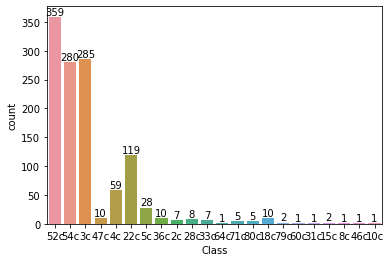

In [530]:
# Distribution of values in the "Class" column
ax = sns.countplot(x="Class", data=df)
ax.bar_label(ax.containers[0])
plt.show()

Here, we noticed that the classes are very imbalanced. For now, we keep this in mind. Further preprocessing steps to deal with this might be necessary.

array([[<AxesSubplot:title={'center':'a6'}>,
        <AxesSubplot:title={'center':'a8'}>,
        <AxesSubplot:title={'center':'a10'}>,
        <AxesSubplot:title={'center':'a12'}>],
       [<AxesSubplot:title={'center':'a14'}>,
        <AxesSubplot:title={'center':'a16'}>,
        <AxesSubplot:title={'center':'a18'}>,
        <AxesSubplot:title={'center':'a20'}>],
       [<AxesSubplot:title={'center':'a22'}>,
        <AxesSubplot:title={'center':'a24'}>,
        <AxesSubplot:title={'center':'a26'}>,
        <AxesSubplot:title={'center':'a28'}>],
       [<AxesSubplot:title={'center':'a30'}>,
        <AxesSubplot:title={'center':'a32'}>,
        <AxesSubplot:title={'center':'a34'}>,
        <AxesSubplot:title={'center':'a36'}>],
       [<AxesSubplot:title={'center':'a38'}>,
        <AxesSubplot:title={'center':'a40'}>,
        <AxesSubplot:title={'center':'a42'}>,
        <AxesSubplot:title={'center':'a44'}>]], dtype=object)

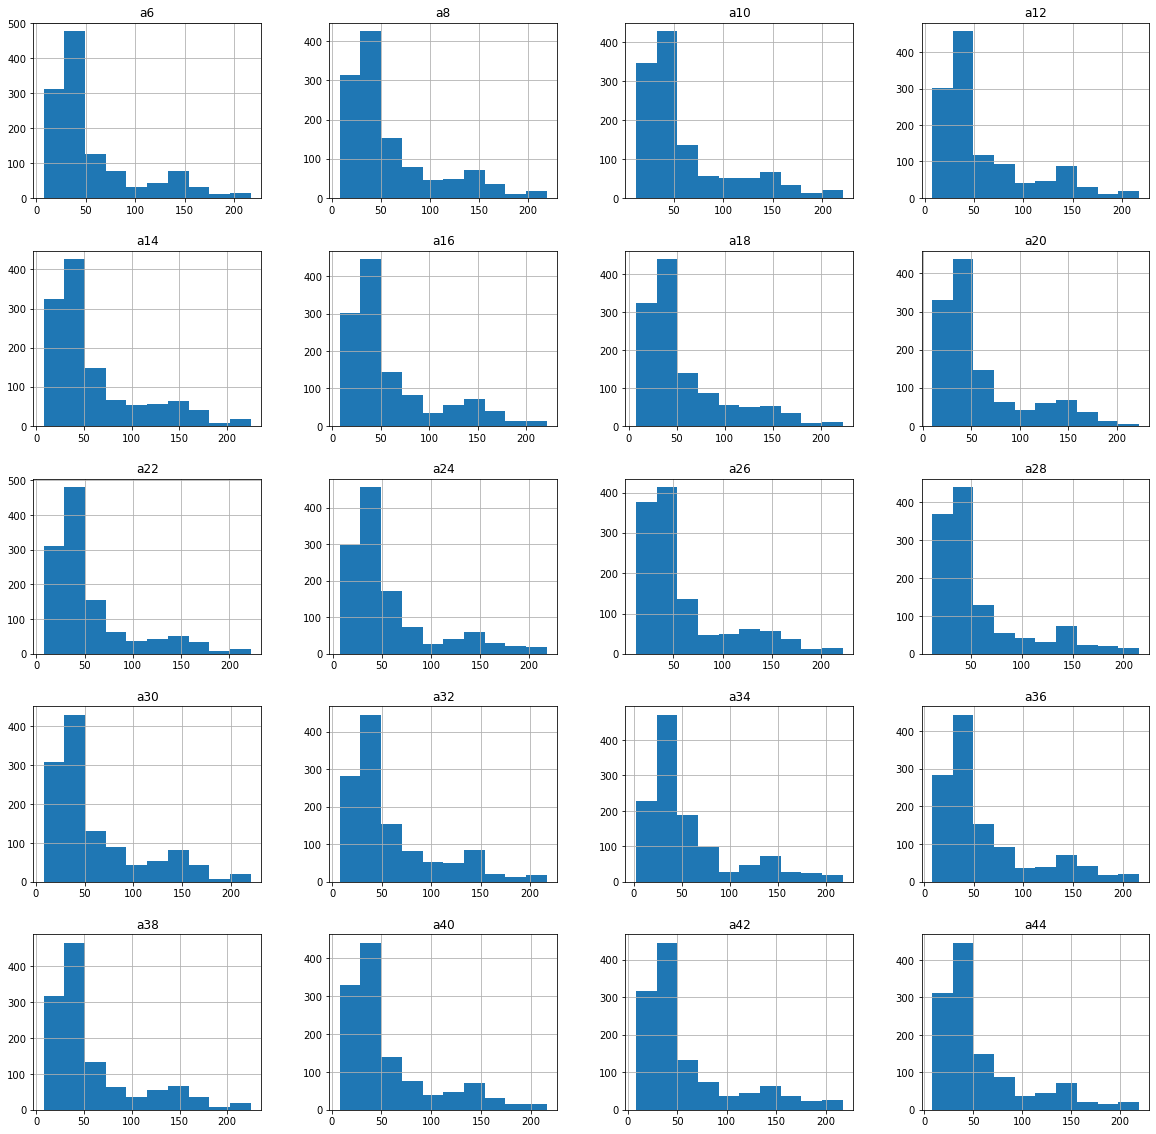

In [531]:
# Plot distribution of each column
df.hist(figsize=(20,20))

We notice that all frequencies are very similarly distributed.

------------------------
### Preprocessing

As decribed in the official paper, some preprocessing can help get better results. For this purpose we will create another dataset df_reduced which will have the reduced multiplicities.

In [532]:
# Create a copy
df_reduced = df.copy()

In [533]:
# For each sample of the dataset
col_names = df_reduced.columns
for i in tqdm(range(len(df_reduced))):
    
    for j in range (len(col_names)):

        if df_reduced[col_names[j]][i] == 's' and df_reduced[col_names[j+1]][i] >= 64.5 and df_reduced[col_names[j+1]][i] <= 95:
            df_reduced[col_names[j]][i] = 'd'

        if df_reduced[col_names[j]][i] == 's' and df_reduced[col_names[j+1]][i] >= 96 and df_reduced[col_names[j+1]][i] <= 114:
            df_reduced[col_names[j]][i] = 't'

        if df_reduced[col_names[j]][i] == 's' and df_reduced[col_names[j+1]][i] >= 115 and df_reduced[col_names[j+1]][i] <= 165:
            df_reduced[col_names[j]][i] = 'd'

        if df_reduced[col_names[j]][i] == 's' and df_reduced[col_names[j+1]][i] >= 165 and df_reduced[col_names[j+1]][i] <= 188:
            df_reduced[col_names[j]][i] = 'q'

        if df_reduced[col_names[j]][i] == 's' and df_reduced[col_names[j+1]][i] >= 188 and df_reduced[col_names[j+1]][i] <= math.inf:
            df_reduced[col_names[j]][i] = 't'


        if df_reduced[col_names[j]][i] == 'd' and df_reduced[col_names[j+1]][i] >= 64.5 and df_reduced[col_names[j+1]][i] <= 95:
            df_reduced[col_names[j]][i] = 't'

        if df_reduced[col_names[j]][i] == 'd' and df_reduced[col_names[j+1]][i] >= 105 and df_reduced[col_names[j+1]][i] <= 180:
            df_reduced[col_names[j]][i] = 't'

        if df_reduced[col_names[j]][i] == 'd' and df_reduced[col_names[j+1]][i] >= 96 and df_reduced[col_names[j+1]][i] <= 104:
            df_reduced[col_names[j]][i] = 'q'

        if df_reduced[col_names[j]][i] == 'd' and df_reduced[col_names[j+1]][i] >= 180 and df_reduced[col_names[j+1]][i] <= math.inf:
            df_reduced[col_names[j]][i] = 'q'


        if df_reduced[col_names[j]][i] == 't' and df_reduced[col_names[j+1]][i] >= 59 and df_reduced[col_names[j+1]][i] <= 90:
            df_reduced[col_names[j]][i] = 'q'

        if df_reduced[col_names[j]][i] == 't' and df_reduced[col_names[j+1]][i] >= 90 and df_reduced[col_names[j+1]][i] <= math.inf:
            df_reduced[col_names[j]][i] = 'q'

100%|█████████████████████████████████████████████████████████████████████████████| 1202/1202 [00:04<00:00, 249.44it/s]


In [534]:
df_reduced.head()

,ID,a5,a6,a7,a8,a9,a10,a11,a12,a13,...,a36,a37,a38,a39,a40,a41,a42,a43,a44,Class
0,v1493,q,139.2,q,33.2,d,30.7,d,49.6,t,...,134.5,t,24.2,q,14.4,t,42.2,t,18.6,52c
1,v1255,q,144.0,q,66.7,d,46.2,t,32.7,q,...,22.4,s,37.7,q,19.7,q,16.5,t,26.6,54c
2,v2194,d,30.7,t,26.8,t,41.2,q,139.3,q,...,16.7,t,35.4,q,65.8,s,42.4,q,139.8,54c
3,v2021,t,37.2,t,17.4,q,16.7,s,58.1,t,...,33.5,d,44.9,d,56.6,q,20.8,t,36.5,3c
4,v1051,q,12.2,q,154.6,t,18.7,t,37.1,q,...,49.5,t,38.8,q,71.4,s,36.8,s,46.2,3c


To deal with the categorical features, we opt for one hot encoding over label encoding, as we are not sure yet how the multiplicities work.

In [535]:
# Categorical columns
categorical_columns = [f"a{i}" for i in range(5, 44, 2)]
# Final names
final_names = []
for i in df_reduced.drop(["ID", "Class"], axis=1).select_dtypes(include=['object']).columns:
    final_names.append(f"{i}_s")
    final_names.append(f"{i}_d")
    final_names.append(f"{i}_t")
    final_names.append(f"{i}_q")
    final_names.append(f"a{int(i[1:]) + 1}")
# Drop the "ID" column
df_reduced = df_reduced.drop(["ID"], axis=1)
# Split the data into features and labels
y = df_reduced["Class"]
X = df_reduced.drop(["Class"], axis=1)
# One hot encoder
enc = OneHotEncoder(sparse=False)
# Fit the encoder
enc.fit(X[categorical_columns])
# Transform the data
X_enc = enc.transform(X[categorical_columns]) #.toarray()
# Create a dataframe from the encoded data
X_enc_df = pd.DataFrame(X_enc)
# Rename
X_enc_df.columns = enc.get_feature_names_out(categorical_columns)
# Concatenate the encoded data with the rest of the data
X = pd.concat([X, X_enc_df], axis=1)
# Drop the categorical columns
X = X.drop(categorical_columns, axis=1)
# Rename
X = X[final_names]
# Inspect
X.head()


,a5_s,a5_d,a5_t,a5_q,a6,a7_s,a7_d,a7_t,a7_q,a8,...,a41_s,a41_d,a41_t,a41_q,a42,a43_s,a43_d,a43_t,a43_q,a44
0,0.0,0.0,0.0,1.0,139.2,0.0,0.0,0.0,1.0,33.2,...,0.0,0.0,1.0,0.0,42.2,0.0,0.0,1.0,0.0,18.6
1,0.0,0.0,0.0,1.0,144.0,0.0,0.0,0.0,1.0,66.7,...,0.0,0.0,0.0,1.0,16.5,0.0,0.0,1.0,0.0,26.6
2,0.0,1.0,0.0,0.0,30.7,0.0,0.0,1.0,0.0,26.8,...,1.0,0.0,0.0,0.0,42.4,0.0,0.0,0.0,1.0,139.8
3,0.0,0.0,1.0,0.0,37.2,0.0,0.0,1.0,0.0,17.4,...,0.0,0.0,0.0,1.0,20.8,0.0,0.0,1.0,0.0,36.5
4,0.0,0.0,0.0,1.0,12.2,0.0,0.0,0.0,1.0,154.6,...,1.0,0.0,0.0,0.0,36.8,1.0,0.0,0.0,0.0,46.2


As it is unsure of what the columns represent, scaling is not done so there is no information loss.

-----------------------
# Classification

We preliminarily try 3 different algorithms to gain the initial intuition of our problem. 

We define a function for faster evaluation of different models. At this stage we are satisfied with hold out for evaluation.

In [536]:
def evaluate(clfs, X, y, plot=True):
    results = []
    
    for clf in clfs:
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
        # Fit the model
        clf.fit(X_train, y_train)
    
        # Make predictions
        y_pred = clf.predict(X_test)
    
        # Get name of the classifier
        name = type(clf).__name__
        
        # Calculate different scores
        res = {
            'Algorithm': name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'F1 macro': f1_score(y_test, y_pred, average='macro'),
            'F1 micro': f1_score(y_test, y_pred, average='micro')
        }
        
        if plot:
            plot_confusion_matrix(clf, X_test, y_test, cmap='rocket_r', xticks_rotation='vertical') 
            plt.title(name)
            plt.show()
        
        results.append(res)
        
    return pd.DataFrame(results)

In [537]:
clfs_to_try = [LogisticRegression(), 
               KNeighborsClassifier(), 
               DecisionTreeClassifier()]
evaluate(clfs_to_try, X, y, plot=False)

,Algorithm,Accuracy,F1 macro,F1 micro
0,LogisticRegression,0.253112,0.045349,0.253112
1,KNeighborsClassifier,0.290456,0.076810,0.290456
2,DecisionTreeClassifier,0.307054,0.073772,0.307054


Our premlinirary evaluation doesn't show a great success. We proceed trying to adapt hyperparameters to better fit our problem.

## Grid Search

In [538]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### K-Nearest Neighbors

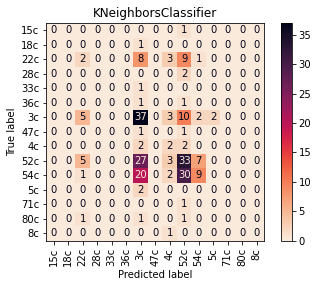

,Algorithm,Accuracy,F1 macro,F1 micro
0,KNeighborsClassifier,0.344398,0.092695,0.344398


In [539]:
# Do a grid search
clf = KNeighborsClassifier()
grid_values = {'n_neighbors':[6,8,10,12,14,16,18,20],
               'leaf_size':list(range(1,50,5)),
               "metric":["euclidean", "manhattan", "chebyshev"],
               'weights':['uniform', 'distance'],
               'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']
              }
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values,scoring = 'accuracy', n_jobs=-1)
grid_clf_acc.fit(X_train, y_train)
evaluate([KNeighborsClassifier(**grid_clf_acc.best_params_)], X, y)

### Decision Tree

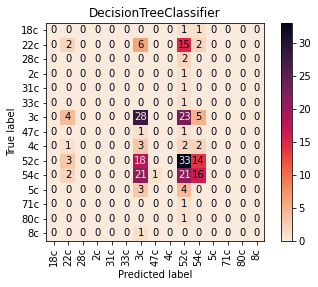

,Algorithm,Accuracy,F1 macro,F1 micro
0,DecisionTreeClassifier,0.327801,0.07995,0.327801


In [540]:
# Do a grid search
clf = DecisionTreeClassifier()
grid_values = {'ccp_alpha': [0.1, 0.01, 0.001, 0.0001, 0],
               'criterion': ['gini', 'entropy'],
               'max_depth': [5, 6, 7, 8, 9, 10, None],
               'max_features': ['auto', 'sqrt', 'log2']
              }
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values,scoring = 'accuracy', n_jobs=-1)
grid_clf_acc.fit(X_train, y_train)
evaluate([DecisionTreeClassifier(**grid_clf_acc.best_params_)], X, y)

### Logistic Regression

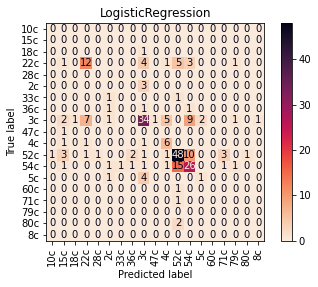

,Algorithm,Accuracy,F1 macro,F1 micro
0,LogisticRegression,0.526971,0.159639,0.526971


In [541]:
# Do a grid search
clf = LogisticRegression()
grid_values = {'penalty': ['l2'], 
               'C':[0.001,.009,0.01,.09,1,5,10,25], 
               'solver':['lbfgs'], 
               'max_iter':[100,1000,2500]
              }
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values,scoring = 'accuracy', n_jobs=-1)
grid_clf_acc.fit(X_train, y_train)
evaluate([LogisticRegression(**grid_clf_acc.best_params_)], X, y)

Hyperparameter tuning seems to be of great help for our problem.

---

# Alternative approach

In the previous section we saw how hyperparameter tuning can largly improve performance of our models. However, the accuracy is still quite low compared to the existing literature. We suspect our very agnostic approach with regard to the provided dataset might be too agnostic for these simple models to detect meaningful patterns. 

In this section we take a more determined approach, making informed guesses on the way the structures of diterpenes work. We must note we are not chemistry professionals so our assumptions might not be fully correct, but they might be good enough.

## Multiplicity assumption

We know our diterpenes have 20 carbon atoms. The multiplicity of a carbon atom seems to be a very important information. We suspect the amount of carbons with a specific multiplicity may already be a big hint for models to discriminate between different diterpenes.

In [542]:
df = pd.read_csv("diterpene_shuf.csv")

# Consider only multiplicity counts
df_simple = df[['a0', 'a1', 'a2', 'a3', 'a45c']]
df_simple.head()

,a0,a1,a2,a3,a45c
0,2,4,8,6,52c
1,2,4,8,6,54c
2,2,4,8,6,54c
3,3,4,9,4,3c
4,3,4,9,4,3c


In [543]:
# Rename columns for better readability
df_simple = df_simple.rename(columns={'a0':'s_cnt', 'a1':'d_cnt', 'a2':'t_cnt', 'a3':'q_cnt', 'a45c':'Class'})

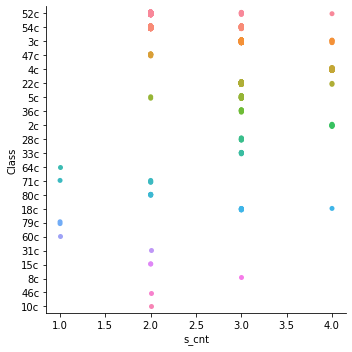

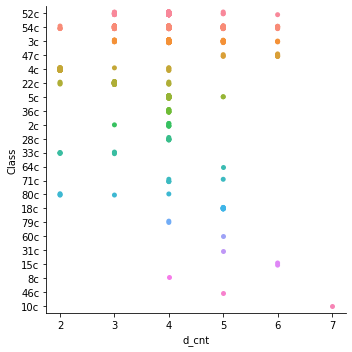

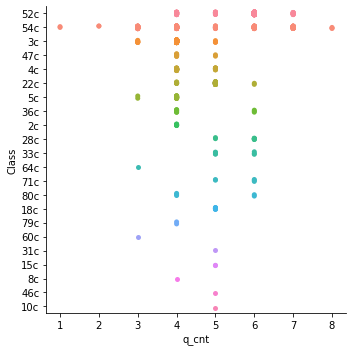

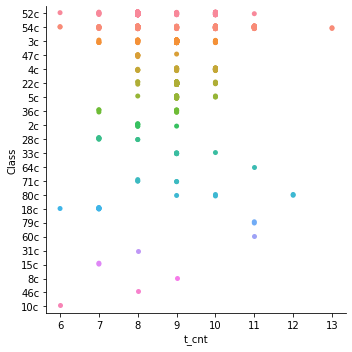

In [544]:
# Plot each multiplicity per class
sns.catplot(data=df_simple, y="Class", x='s_cnt')
sns.catplot(data=df_simple, y="Class", x='d_cnt')
sns.catplot(data=df_simple, y="Class", x='q_cnt')
sns.catplot(data=df_simple, y="Class", x='t_cnt')

We can see there could be some regularities in this, for example diterpene 52c (our majority class) never has 1 singulet, it always has 2, 3 or 4. This seems promising. Let's check.

In [545]:
X = df_simple[['s_cnt', 'd_cnt', 't_cnt', 'q_cnt']]
y = df_simple['Class']
evaluate(clfs_to_try, X, y, plot=False)

,Algorithm,Accuracy,F1 macro,F1 micro
0,LogisticRegression,0.726141,0.245911,0.726141
1,KNeighborsClassifier,0.639004,0.300120,0.639004
2,DecisionTreeClassifier,0.755187,0.378595,0.755187


Indeed, it seems like the information about multiplicity brings good discriminatory value to our models.

## Insignificance of order assumption

Although the multiplicity already brings a lot of information, we want to also somehow incorporate the frequency information into our models.

In [546]:
# Get the rest of features
df_rest = df.drop(columns=['a0', 'a1', 'a2', 'a3','a4', 'a45c'])
df_rest.head()

,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,...,a35,a36,a37,a38,a39,a40,a41,a42,a43,a44
0,t,139.2,q,33.2,d,30.7,d,49.6,t,38.6,...,d,134.5,t,24.2,q,14.4,t,42.2,t,18.6
1,d,144.0,q,66.7,d,46.2,t,32.7,q,19.1,...,t,22.4,s,37.7,q,19.7,q,16.5,t,26.6
2,d,30.7,t,26.8,t,41.2,t,139.3,q,19.8,...,t,16.7,t,35.4,q,65.8,s,42.4,d,139.8
3,t,37.2,t,17.4,q,16.7,s,58.1,t,41.6,...,s,33.5,d,44.9,d,56.6,q,20.8,t,36.5
4,q,12.2,d,154.6,t,18.7,t,37.1,t,79.1,...,d,49.5,t,38.8,t,71.4,s,36.8,s,46.2


As previously mentioned, we know we have multiple multiplicity-frequency pairs for each diterpene structure. We will assume the order of the pairs is not important, and sum up frequencies for each multiplicity as new features for our models.

In [547]:
t = []
q = []
s = []
d = []
cols = df_rest.columns.values

# Consider each structure individually
for index, row in df_rest.iterrows():
    # Add up frequencies for each multiplicity
    tval = qval = sval = dval = 0
    for i in range(1, len(cols), 2):
        mul = row[cols[i-1]]
        freq = row[cols[i]]
        if mul == 't':
            tval = tval + freq
        elif mul == 'q':
            qval = qval + freq
        elif mul == 's':
            sval = sval + freq
        elif mul == 'd':
            dval = dval + freq
    t.append(tval)
    q.append(qval)
    s.append(sval)
    d.append(dval)
    
X['t_freq'] = t
X['q_freq'] = q
X['s_freq'] = s
X['d_freq'] = d

In [548]:
X.head()

,s_cnt,d_cnt,t_cnt,q_cnt,t_freq,q_freq,s_freq,d_freq
0,2,4,8,6,368.0,323.3,69.8,266.1
1,2,4,8,6,415.2,199.1,75.7,371.1
2,2,4,8,6,347.0,463.2,80.8,252.7
3,3,4,9,4,473.9,139.1,131.7,234.0
4,3,4,9,4,409.9,203.4,123.0,323.1


In [549]:
evaluate(clfs_to_try, X, y, plot=False)

,Algorithm,Accuracy,F1 macro,F1 micro
0,LogisticRegression,0.651452,0.237991,0.651452
1,KNeighborsClassifier,0.721992,0.439648,0.721992
2,DecisionTreeClassifier,0.829876,0.600282,0.829876


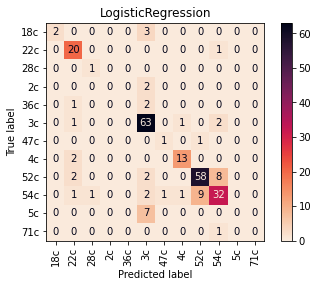

,Algorithm,Accuracy,F1 macro,F1 micro
0,LogisticRegression,0.788382,0.48611,0.788382


In [550]:
# Do a grid search
clf = LogisticRegression()
grid_values = {'penalty': ['l2'], 
               'C':[0.001,.009,0.01,.09,1,5,10,25], 
               'solver':['lbfgs'], 
               'max_iter':[100,1000,2500]
              }
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values,scoring = 'accuracy', n_jobs=-1)
grid_clf_acc.fit(X_train, y_train)
evaluate([LogisticRegression(**grid_clf_acc.best_params_)], X, y)

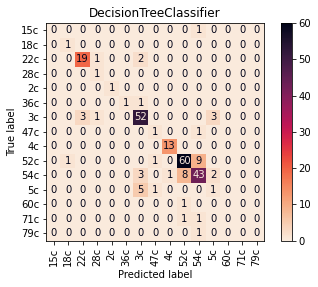

,Algorithm,Accuracy,F1 macro,F1 micro
0,DecisionTreeClassifier,0.80083,0.511891,0.80083


In [551]:
# Do a grid search
clf = DecisionTreeClassifier(random_state=reproduce)
grid_values = {'ccp_alpha': [0.1, 0.01, 0.001, 0.0001, 0],
               'criterion': ['gini', 'entropy'],
               'max_depth': [5, 6, 7, 8, 9, 10, None],
               'max_features': ['auto', 'sqrt', 'log2']
              }
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values,scoring = 'accuracy', n_jobs=-1)
grid_clf_acc.fit(X_train, y_train)
evaluate([DecisionTreeClassifier(**grid_clf_acc.best_params_)], X, y)

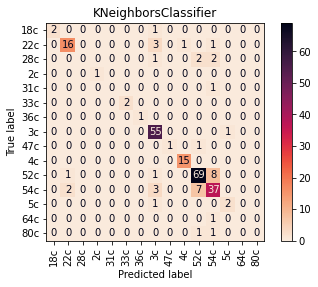

,Algorithm,Accuracy,F1 macro,F1 micro
0,KNeighborsClassifier,0.834025,0.627873,0.834025


In [552]:
# Do a grid search
clf = KNeighborsClassifier()
grid_values = {'n_neighbors':[6,8,10,12,14,16,18,20],
               'leaf_size':list(range(1,50,5)),
               "metric":["euclidean", "manhattan", "chebyshev"],
               'weights':['uniform', 'distance'],
               'algorithm':['auto', 'ball_tree', 'kd_tree', 'brute']
              }
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values,scoring = 'accuracy', n_jobs=-1)
grid_clf_acc.fit(X_train, y_train)
evaluate([KNeighborsClassifier(**grid_clf_acc.best_params_)], X, y)

### Proceeding with KNN

In [554]:
score = cross_val_score(KNeighborsClassifier(**grid_clf_acc.best_params_), X=X, y=y)

In [568]:
print("{:.4} +/- {:.4}".format(np.mean(score), np.std(score)))

0.8353 +/- 0.02487
